In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests

from collections import Counter

from PIL import Image
from io import BytesIO

warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
from classes.WGAN import WGAN

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline


from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


### loading data

In [3]:
import cv2

def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath

def load_images(directory='', size=(64,64)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0

    imagePaths = list(list_images(directory))

    for path in imagePaths:

        if not('OSX' in path):

            path = path.replace('\\','/')

            image = cv2.imread(path) #Reading the image with OpenCV
            image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    return images

In [4]:
images=load_images('data')

### reshaping images, making train val test sets and plotting example images

In [5]:
# Convert list with images to numpy array and reshape it
X = np.array(images).reshape(-1, 64, 64, 3)

# Scaling data in array
X = X / 255.0

from sklearn.model_selection import train_test_split

# Splitting data to train and test datasets
X_train, X_test = train_test_split(X, test_size = 0.2, shuffle = True, random_state = 66)

In [6]:
n = int(len(X_test)/2)
X_valid = X_test[:n]
X_test = X_test[n:]

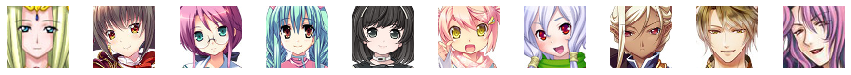

In [7]:
n_to_show = 10
example_idx = np.random.choice(range(len(X)), n_to_show)
example_images = X[example_idx]


fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.imshow(img)

In [13]:
X_train.shape

(17240, 64, 64, 3)

### building GAN architecture

In [21]:
gan = WGAN(input_dim = (64,64,3)
        , critic_conv_filters = [32,64,128,128]
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,1]
        , critic_batch_norm_momentum = None
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.00005
        , generator_initial_dense_layer_size = (4, 4, 128)
        , generator_upsample = [2,2, 2,2]
        , generator_conv_filters = [128,64,32,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [1,1, 1,1]
        , generator_batch_norm_momentum = 0.8
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.00005
        , optimiser = 'rmsprop'
        , z_dim = 100
            )

In [22]:
gan.generator.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_13 (Batc (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 2048)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 8, 8, 128)         0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 8, 8, 128)         409

In [23]:
gan.critic.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 64, 64, 3)         0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 32, 32, 32)        2432      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
critic_conv_2 (Conv2D)       (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 8, 8, 128)         0  

### training the gan

In [67]:
BATCH_SIZE = 128
EPOCHS = 20000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5
CLIP_THRESHOLD = 0.01

In [105]:
gan.train(     
    X_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = 'RUN_FOLDER'
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , clip_threshold = CLIP_THRESHOLD
)

15704 [D loss: (-0.035)(R -0.068, F -0.003)]  [G loss: 0.078] 
15705 [D loss: (-0.049)(R -0.087, F -0.012)]  [G loss: 0.085] 
15706 [D loss: (-0.016)(R -0.056, F 0.024)]  [G loss: 0.075] 
15707 [D loss: (-0.037)(R -0.059, F -0.015)]  [G loss: 0.083] 
15708 [D loss: (-0.044)(R -0.058, F -0.031)]  [G loss: 0.104] 
15709 [D loss: (-0.035)(R -0.032, F -0.038)]  [G loss: 0.107] 
15710 [D loss: (-0.038)(R -0.038, F -0.037)]  [G loss: 0.106] 
15711 [D loss: (-0.038)(R -0.038, F -0.038)]  [G loss: 0.091] 
15712 [D loss: (-0.037)(R -0.068, F -0.006)]  [G loss: 0.091] 
15713 [D loss: (-0.046)(R -0.060, F -0.031)]  [G loss: 0.089] 
15714 [D loss: (-0.044)(R -0.068, F -0.021)]  [G loss: 0.077] 
15715 [D loss: (-0.035)(R -0.056, F -0.015)]  [G loss: 0.086] 
15716 [D loss: (-0.044)(R -0.079, F -0.010)]  [G loss: 0.077] 
15717 [D loss: (-0.025)(R -0.068, F 0.018)]  [G loss: 0.055] 
15718 [D loss: (-0.033)(R -0.054, F -0.013)]  [G loss: 0.078] 
15719 [D loss: (-0.052)(R -0.073, F -0.031)]  [G loss: 0.

15835 [D loss: (-0.037)(R -0.077, F 0.003)]  [G loss: 0.072] 
15836 [D loss: (-0.042)(R -0.077, F -0.007)]  [G loss: 0.067] 
15837 [D loss: (-0.040)(R -0.065, F -0.015)]  [G loss: 0.078] 
15838 [D loss: (-0.045)(R -0.060, F -0.030)]  [G loss: 0.083] 
15839 [D loss: (-0.044)(R -0.070, F -0.018)]  [G loss: 0.085] 
15840 [D loss: (-0.046)(R -0.070, F -0.022)]  [G loss: 0.093] 
15841 [D loss: (-0.049)(R -0.087, F -0.011)]  [G loss: 0.082] 
15842 [D loss: (-0.028)(R -0.029, F -0.028)]  [G loss: 0.098] 
15843 [D loss: (-0.036)(R -0.061, F -0.010)]  [G loss: 0.078] 
15844 [D loss: (-0.043)(R -0.074, F -0.013)]  [G loss: 0.079] 
15845 [D loss: (-0.047)(R -0.082, F -0.012)]  [G loss: 0.084] 
15846 [D loss: (-0.040)(R -0.070, F -0.011)]  [G loss: 0.079] 
15847 [D loss: (-0.044)(R -0.071, F -0.017)]  [G loss: 0.087] 
15848 [D loss: (-0.033)(R -0.054, F -0.012)]  [G loss: 0.070] 
15849 [D loss: (-0.042)(R -0.050, F -0.034)]  [G loss: 0.100] 
15850 [D loss: (-0.041)(R -0.063, F -0.018)]  [G loss: 0

15966 [D loss: (-0.046)(R -0.087, F -0.005)]  [G loss: 0.067] 
15967 [D loss: (-0.040)(R -0.081, F 0.002)]  [G loss: 0.068] 
15968 [D loss: (-0.045)(R -0.083, F -0.008)]  [G loss: 0.076] 
15969 [D loss: (-0.052)(R -0.095, F -0.010)]  [G loss: 0.067] 
15970 [D loss: (-0.040)(R -0.086, F 0.006)]  [G loss: 0.067] 
15971 [D loss: (-0.039)(R -0.069, F -0.010)]  [G loss: 0.081] 
15972 [D loss: (-0.042)(R -0.088, F 0.004)]  [G loss: 0.068] 
15973 [D loss: (-0.036)(R -0.064, F -0.009)]  [G loss: 0.071] 
15974 [D loss: (-0.039)(R -0.067, F -0.012)]  [G loss: 0.074] 
15975 [D loss: (-0.048)(R -0.087, F -0.009)]  [G loss: 0.075] 
15976 [D loss: (-0.034)(R -0.041, F -0.028)]  [G loss: 0.074] 
15977 [D loss: (-0.026)(R -0.043, F -0.009)]  [G loss: 0.081] 
15978 [D loss: (-0.029)(R -0.037, F -0.022)]  [G loss: 0.090] 
15979 [D loss: (-0.050)(R -0.074, F -0.027)]  [G loss: 0.095] 
15980 [D loss: (-0.048)(R -0.066, F -0.030)]  [G loss: 0.080] 
15981 [D loss: (-0.035)(R -0.055, F -0.016)]  [G loss: 0.0

16097 [D loss: (-0.040)(R -0.074, F -0.006)]  [G loss: 0.062] 
16098 [D loss: (-0.040)(R -0.085, F 0.006)]  [G loss: 0.073] 
16099 [D loss: (-0.038)(R -0.077, F 0.000)]  [G loss: 0.076] 
16100 [D loss: (-0.035)(R -0.066, F -0.004)]  [G loss: 0.090] 
16101 [D loss: (-0.037)(R -0.072, F -0.002)]  [G loss: 0.067] 
16102 [D loss: (-0.049)(R -0.073, F -0.025)]  [G loss: 0.089] 
16103 [D loss: (-0.030)(R -0.026, F -0.034)]  [G loss: 0.079] 
16104 [D loss: (-0.053)(R -0.058, F -0.048)]  [G loss: 0.103] 
16105 [D loss: (-0.036)(R -0.049, F -0.022)]  [G loss: 0.113] 
16106 [D loss: (-0.045)(R -0.049, F -0.042)]  [G loss: 0.099] 
16107 [D loss: (-0.038)(R -0.049, F -0.027)]  [G loss: 0.072] 
16108 [D loss: (-0.045)(R -0.063, F -0.027)]  [G loss: 0.059] 
16109 [D loss: (-0.031)(R -0.061, F -0.001)]  [G loss: 0.095] 
16110 [D loss: (-0.034)(R -0.073, F 0.006)]  [G loss: 0.055] 
16111 [D loss: (-0.040)(R -0.080, F 0.000)]  [G loss: 0.067] 
16112 [D loss: (-0.024)(R -0.033, F -0.015)]  [G loss: 0.07

16228 [D loss: (-0.038)(R -0.060, F -0.016)]  [G loss: 0.078] 
16229 [D loss: (-0.033)(R -0.051, F -0.015)]  [G loss: 0.090] 
16230 [D loss: (-0.047)(R -0.062, F -0.032)]  [G loss: 0.085] 
16231 [D loss: (-0.041)(R -0.062, F -0.020)]  [G loss: 0.080] 
16232 [D loss: (-0.036)(R -0.052, F -0.021)]  [G loss: 0.090] 
16233 [D loss: (-0.021)(R -0.035, F -0.007)]  [G loss: 0.069] 
16234 [D loss: (-0.041)(R -0.066, F -0.015)]  [G loss: 0.071] 
16235 [D loss: (-0.041)(R -0.082, F -0.001)]  [G loss: 0.062] 
16236 [D loss: (-0.045)(R -0.075, F -0.014)]  [G loss: 0.075] 
16237 [D loss: (-0.036)(R -0.069, F -0.002)]  [G loss: 0.062] 
16238 [D loss: (-0.039)(R -0.070, F -0.008)]  [G loss: 0.081] 
16239 [D loss: (-0.044)(R -0.062, F -0.027)]  [G loss: 0.089] 
16240 [D loss: (-0.039)(R -0.055, F -0.023)]  [G loss: 0.078] 
16241 [D loss: (-0.041)(R -0.063, F -0.019)]  [G loss: 0.086] 
16242 [D loss: (-0.038)(R -0.049, F -0.026)]  [G loss: 0.077] 
16243 [D loss: (-0.040)(R -0.058, F -0.021)]  [G loss: 

KeyboardInterrupt: 

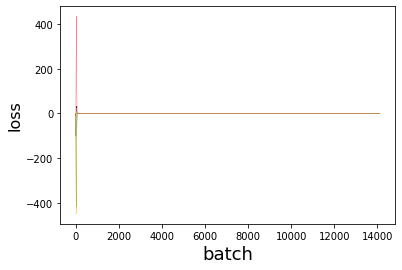

In [102]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

# plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()

### generating sample input images

In [41]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

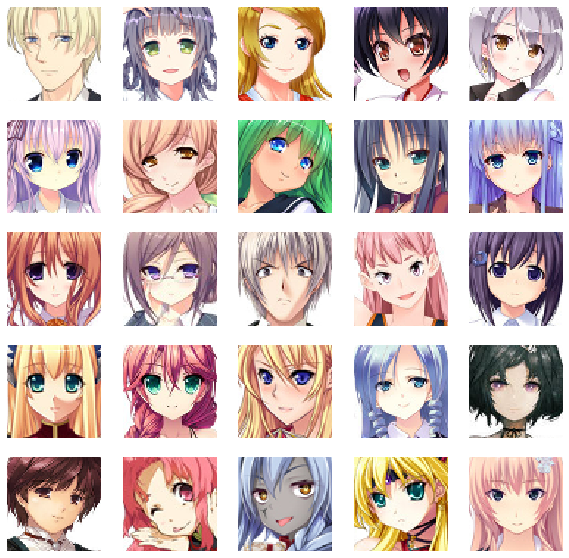

In [45]:
r, c = 5, 5

idx = np.random.randint(0, X_train.shape[0], BATCH_SIZE)
#true_imgs = (X_train[idx] + 1) *0.5
true_imgs = X_train[idx]

fig, axs = plt.subplots(r, c, figsize=(10,10))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(true_imgs[cnt])#, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig("model_images/GAN_real.png")


### generating new images from random points

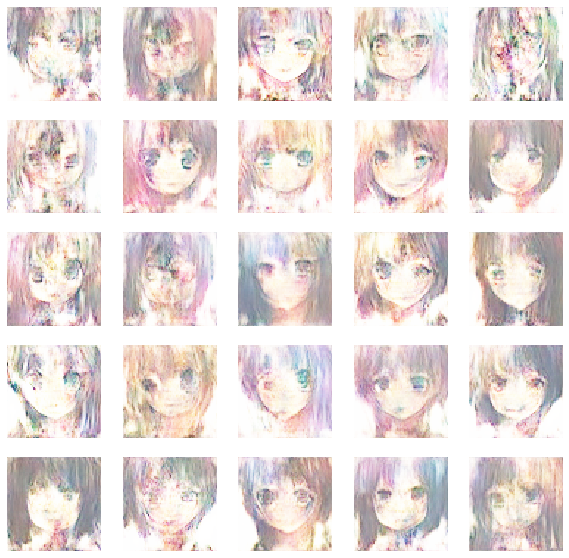

In [106]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.z_dim))
gen_imgs = gan.generator.predict(noise)

#Rescale images 0 - 1

gen_imgs = 0.5 * (gen_imgs + 1)
# gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(10, 10))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig("model_images/GAN_sample_16333.png")


### finding the training images closest to the new images 

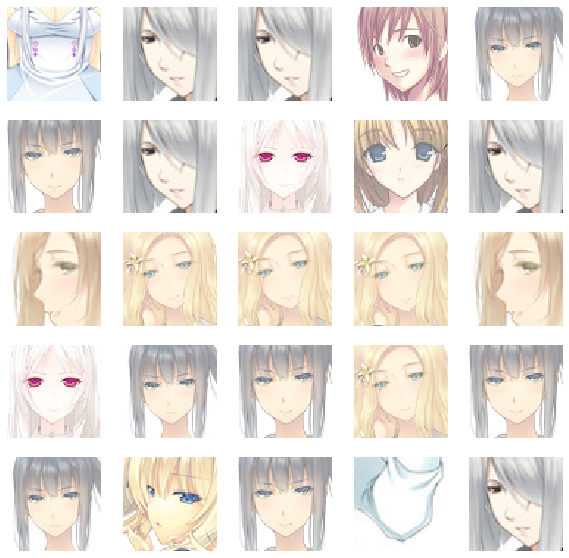

In [100]:
fig, axs = plt.subplots(r, c, figsize=(10,10))
cnt = 0

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(X_train): #((X_train + 1) * 0.5):
            
            diff = compare_images(gen_imgs[cnt, :,:,:], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img)#, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

fig.savefig("model_images/GAN_sample_closest.png")


In [101]:
gan.model.save("saved_models/gan_model.h5")
gan.critic.save("saved_models/gan_critic.h5")
gan.generator.save("saved_models/gan_generator.h5")
gan.model.save_weights("saved_models/gan_model_weights.h5")

In [91]:
from keras.models import load_model

model_A = keras.models.load_model("saved_models/gan_model.h5")

model_B = load_weights("saved_models/gan_model_weights.h5")

ValueError: Unknown loss function:wasserstein